In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
pip install -U pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210078 sha256=d50d58a4e3de1fa5bd5e78933a56c0ff373edb6e1ad1b72eee13039fd867697a
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [ ]:
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.util.plotting import plot
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

from mpl_toolkits.mplot3d import axes3d

import plotly.graph_objects as go
import time

from pymoo.indicators.hv import HV

import os
os.chdir('/content/drive/MyDrive/New_MOACOR')
cwd= os.getcwd()

%run moacor_functions

In [ ]:
# Plot the points in 3 dimensions.
def plot_3d(points, title):
    x, y, z = zip(*points)
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x,y,z)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_zlabel("f3")
    ax.set_title(title)
    ax.view_init(45, 45, 0)
    plt.show()

# Plot the points in 3 dimensions.
def plot_2d(points, title):
    x, y = zip(*points)
    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.scatter(x,y)
    ax.set_xlabel("f1")
    ax.set_ylabel("f2")
    ax.set_title(title)
    plt.show()

# Plot the parallel coordinates.
def parallel_plot(points,title):
    final_evals_df = pd.DataFrame(points)
    final_evals_df['Color'] = 1
    plt.figure(figsize=(4, 2))
    parallel_coordinates(final_evals_df,'Color', colormap='viridis', linewidth=1)
    plt.title(title)
    plt.xlabel('Objective')
    plt.ylabel('Evaluation')
    plt.show()

In [ ]:
def selection_weights(q,k):
    ranking_array = np.empty([1])
    part1 = 1 / ( q * k * ( 2 * np.pi) ** 0.5)
    for i in range(k):
        part2 = np.exp( - ( ((i)**2) / (2 * q**2 * k**2) ) )
        weight = part1*part2
        ranking_array = np.vstack((ranking_array,weight))
    ranking_array = np.delete(ranking_array,0,0)
    return ranking_array

In [ ]:
def ranking(q,k,archive):
    a = archive.shape[1]
    rank = []
    part1 = 1 / ( q * k * ( 2 * np.pi) ** 0.5)
    for i in range(k):
        part2 = np.exp( - ( ((i)**2) / (2 * q**2 * k**2) ) )
        weight = part1*part2
        archive[i][a-1] = weight
    return archive

In [ ]:
def evaluate_function(problem, sols_to_eval, n_funcs, n_vars, inverted_flag):
    if ("DTLZ" in problem):
        ref_dirs = get_reference_directions("das-dennis", n_funcs, n_partitions=12)
        problem_pymoo = get_problem(problem, n_var=n_vars, n_obj=n_funcs)
        evaluations = problem_pymoo.evaluate(sols_to_eval)
    elif ("WFG" in problem):
        k_var = ( n_funcs - 1 ) * 2
        if n_funcs < 3:
            k_var = 4
        ref_dirs = get_reference_directions("das-dennis", n_funcs, n_partitions=12)
        problem_pymoo = get_problem(problem, n_var=n_vars, n_obj=n_funcs, k=k_var)
        evaluations = problem_pymoo.evaluate(sols_to_eval)
    else:
        evaluations = evaluate_solutions(sols_to_eval, n_funcs, problem, n_vars)
    if (inverted_flag):
        evaluations = -1 * evaluations
    return evaluations

In [ ]:
def normalize(archive):
    ideal = ideal_vector(archive)
    nadir = nadir_vector(archive)
    normalized_archive = archive.copy()
    n_funcs = archive.shape[1]
    count = 0
    for p in archive:
        for i in range(n_funcs):
            if nadir[i] == ideal[i]:
                a = (p[i]-ideal[i])/(0.000001)
            else:
                a = (p[i]-ideal[i])/(nadir[i]-ideal[i])
            normalized_archive[count,i] = a
        count = count + 1
    return normalized_archive

In [ ]:
def chooseSolution_2(archive,n_vars,n_funcs):
    k = archive.shape[0]
    sumatory = 0
    for x in range(k):
        sumatory = archive[x][n_funcs+n_vars + 1] + sumatory
    rand = np.random.uniform() * sumatory
    sumatory = 0
    for y in range(k):
        sumatory = archive[y][n_funcs+n_vars + 1] + sumatory
        if (sumatory > rand):
            chosen_sol = archive[y]
            break
    return chosen_sol

All good to start, validation complete
Total experiments:  6
Experiment Completed:  1
Elapsed time:  464.6878776550293


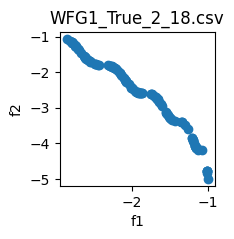

Experiment Completed:  2
Elapsed time:  489.1603410243988


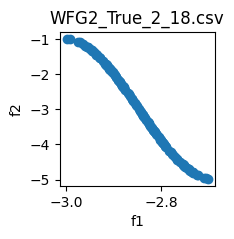

Experiment Completed:  3
Elapsed time:  473.08430910110474


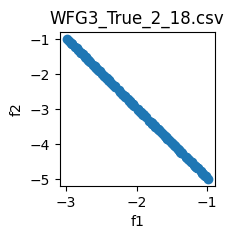

Experiment Completed:  4
Elapsed time:  493.93995809555054


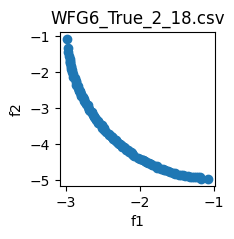

Experiment Completed:  5
Elapsed time:  486.3501479625702


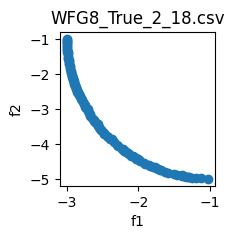

Experiment Completed:  6
Elapsed time:  544.1658747196198


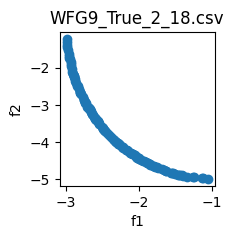

All good to start, validation complete
Total experiments:  6
Experiment Completed:  1
Elapsed time:  471.78565311431885


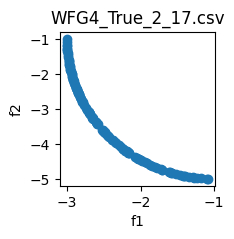

Experiment Completed:  2
Elapsed time:  457.2963032722473


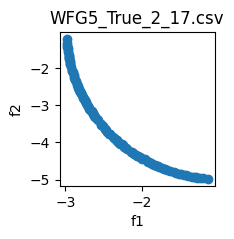

Experiment Completed:  3
Elapsed time:  492.25527358055115


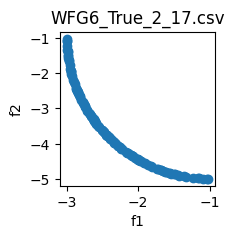

Experiment Completed:  4
Elapsed time:  462.99120140075684


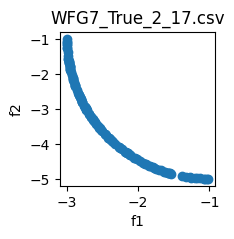

Experiment Completed:  5
Elapsed time:  507.4620933532715


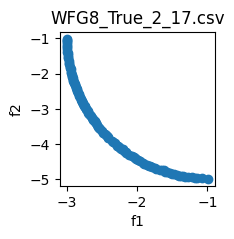

Experiment Completed:  6
Elapsed time:  551.0523006916046


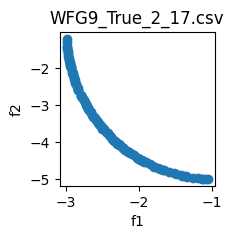

In [ ]:
seed_arr = [1]

for seed in seed_arr:


    # This is for 2 objectives.
    n_funcs = 2
    total_evals = 40000
    n_final = 120

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "IMOP1","IMOP2","IMOP3",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True]

    n_vars_arr = [6,11,11,11,11,11,21,
                  6,11,11,11,11,11,21,
                  10,10,10,
                  24,24,24,24,24,24,24,24,24,
                  24,24,24,24,24,24,24,24,24]

    '''
    # This is for 3 objectives.
    n_funcs = 3
    total_evals = 50000
    n_final = 120

    problem_arr = ["DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "DTLZ1","DTLZ2","DTLZ3","DTLZ4","DTLZ5","DTLZ6","DTLZ7",
                  "IMOP4","IMOP5","IMOP6","IMOP7","IMOP8",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "WFG1","WFG2","WFG3","WFG4","WFG5","WFG6","WFG7","WFG8","WFG9",
                  "VIE1","VIE2","VIE3"]

    inverted_flag_arr = [False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,
                        False,False,False,False,False,
                        False,False,False,False,False,False,False,False,False,
                        True,True,True,True,True,True,True,True,True,
                        False,False,False]

    n_vars_arr = [7,12,12,12,12,12,22,
                  7,12,12,12,12,12,22,
                  10,10,10,10,10,
                  26,26,26,26,26,26,26,26,26,
                  26,26,26,26,26,26,26,26,26,
                  2,2,2]
    '''


    if len(problem_arr) == len(n_vars_arr) and len(problem_arr) == len(inverted_flag_arr):
        print('All good to start, validation complete')

    total_different_experiments = len(problem_arr)
    print('Total experiments: ', total_different_experiments)

    for current in range(total_different_experiments):

        current = current

        # Problem Variables.
        problem = problem_arr[current]
        inverted_flag = inverted_flag_arr[current]
        n_vars = n_vars_arr[current]

        np.random.seed(seed)
        start_time = time.time()

        k = n_final

        n_sols = k
        n_fronts = n_sols
        epsilon = 0.5 # Influences the standard deviation, the bigger the more random.
        q = 0.1

        ants = 2

        mop_data = mop_data_func(n_vars,problem)
        sols = initial_random_solutions(mop_data,n_sols)
        eval_sols = evaluate_function(problem, sols, n_funcs, n_vars, inverted_flag)

        # all crowding distances only works if there are at least 3 points
        best_sols_eval,best_sols,frontier = keep_solutions(sols,eval_sols,n_fronts,k)
        #print(frontier)
        archive = concatenate_archive(best_sols,best_sols_eval,frontier,n_vars,n_funcs)

        ranking_array = selection_weights(q,k)

        archive = np.concatenate((archive,ranking_array), axis=1)

        fn_evals = n_sols
        gen = 1

        file_to_save = np.empty([n_vars + n_funcs + 1])

        # Stack the output at the moment to the final archive that will be uploaded.
        output_at_the_moment = archive[:,:n_vars + n_funcs]
        generation_array = np.zeros((output_at_the_moment.shape[0],1))
        for i in range(output_at_the_moment.shape[0]):
            generation_array[i] = fn_evals
        generation_to_save = np.concatenate((output_at_the_moment, generation_array), axis=1)
        file_to_save = np.vstack((file_to_save,generation_to_save))

        while fn_evals < total_evals:

            for ant in range(ants):
                chosen_sol = chooseSolution_2(archive,n_vars,n_funcs)
                new_modified_sol = newSolution(archive,chosen_sol[:n_vars],epsilon,mop_data,n_vars)
                best_sols = np.vstack((best_sols,[new_modified_sol]))

            new_eval_sols = evaluate_function(problem, best_sols, n_funcs, n_vars, inverted_flag)
            best_sols_eval,best_sols,frontier = keep_solutions(best_sols,new_eval_sols,n_fronts,k)
            archive = concatenate_archive(best_sols,best_sols_eval,frontier,n_vars,n_funcs)

            if archive.shape[0] > k-1:
                archive = delete_sols(archive,k)
                best_sols = archive[:,:n_vars]

            archive = np.concatenate((archive,ranking_array), axis=1)

            fn_evals = fn_evals + ants
            gen = gen + 1

            if ((gen)%100) == 0:
                # Stack the output at the moment to the final archive that will be uploaded.
                output_at_the_moment = archive[:,:n_vars + n_funcs]
                generation_array = np.zeros((output_at_the_moment.shape[0],1))
                for i in range(output_at_the_moment.shape[0]):
                    generation_array[i] = fn_evals
                generation_to_save = np.concatenate((output_at_the_moment, generation_array), axis=1)
                file_to_save = np.vstack((file_to_save,generation_to_save))

        # Stack the output at the moment to the final archive that will be uploaded.
        output_at_the_moment = archive[:,:n_vars + n_funcs]
        generation_array = np.zeros((output_at_the_moment.shape[0],1))
        for i in range(output_at_the_moment.shape[0]):
            generation_array[i] = fn_evals
        generation_to_save = np.concatenate((output_at_the_moment, generation_array), axis=1)
        file_to_save = np.vstack((file_to_save,generation_to_save))

        file_to_save = np.delete(file_to_save,0,0)
        df = pd.DataFrame(file_to_save)
        tile_of_file = problem + "_" + str(inverted_flag) + "_" + str(n_funcs) + "_" + str(seed) + ".csv"
        df.to_csv("/content/drive/MyDrive/MOACOR/" + tile_of_file)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print('Experiment Completed: ', current + 1)
        print("Elapsed time: ", elapsed_time)

        plot_2d(output_at_the_moment[:,n_vars:n_vars+n_funcs], tile_of_file)